In [7]:
import os
os.getcwd()

'D:\\Geosciences_Project\\Nowcasting_OF'

In [8]:
root_path = os.getcwd()

In [9]:
# Import Necessary Libraries
import numpy as np
from datetime import datetime
import pysteps
# Import utility functions from the repository (custom functions for data loading and other functionalities
import utility   

In [10]:
# Define the data directory for the repository data
data_path = os.path.join(root_path, "Data")
# Define metadata files
metadata_X = utility.get_matadata(os.path.join(data_path, "radarmappatipo.tif"), type="X")
# metadata_C = utility.get_matadata(os.path.join(data_path, "civilpromap.tiff"), type="C")

# Look for Event folder

In [11]:
# List all folders in the data path
folders = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
folders

['Civil_Pro_C', 'UNICA_SG']

In [12]:
events = [event for event in os.listdir(os.path.join(data_path,'UNICA_SG')) if os.path.isdir(os.path.join(data_path, 'UNICA_SG', event))]
events

['20180505_1745',
 '20181014_0515',
 '20190320_0005',
 '20190412_1220',
 '20191024_0415',
 '20191111_0710',
 '20191222_0900',
 '20200120_1440',
 '20200911_1315',
 '20230129_2215',
 '20230302_0245',
 '20230513_1455',
 '20230520_2235']

# Check the number of file available for analysis

In [13]:
count_events = [utility.count_files(os.path.join(data_path, 'UNICA_SG', events[i]), 'png') for i in range(len(events))]
count_events

[73, 56, 39, 36, 12, 38, 38, 55, 45, 39, 52, 63, 62]

# Load and Process X-Band Radar Data

In [14]:
# Define parameters for X-band radar data
data_source_X = 'UNICA_SG'
f_ext_X = "png"
num_prev_files =11
timestep = 5
# Choose the event date
date = datetime.strptime(events[3], "%Y%m%d_%H%M")
# Load X-band radar data
R_X, metadata_X = utility.import_files_by_date(date, data_path, data_source_X, f_ext_X, metadata_X, num_prev_files, timestep)

In [15]:
# Verify results
print("Radar Data Shape:", R_X.shape)
print("Timestamps:", metadata_X["timestamps"])

Radar Data Shape: (12, 1024, 1024)
Timestamps: [datetime.datetime(2019, 4, 12, 11, 25)
 datetime.datetime(2019, 4, 12, 11, 30)
 datetime.datetime(2019, 4, 12, 11, 35)
 datetime.datetime(2019, 4, 12, 11, 40)
 datetime.datetime(2019, 4, 12, 11, 45)
 datetime.datetime(2019, 4, 12, 11, 50)
 datetime.datetime(2019, 4, 12, 11, 55)
 datetime.datetime(2019, 4, 12, 12, 0)
 datetime.datetime(2019, 4, 12, 12, 5)
 datetime.datetime(2019, 4, 12, 12, 10)
 datetime.datetime(2019, 4, 12, 12, 15)
 datetime.datetime(2019, 4, 12, 12, 20)]


# Noise Removal

In [16]:
# Noise removal using Watershed technique
R_X_clean = np.empty_like(R_X)
for t in range(R_X.shape[0]):
    R_X_clean[t, :, :] = utility.noise_remove(R_X[t, :, :], type="Watershed")

# Data Transfromation

In [17]:
# Convert Digital Number to Reflectivity (dBZ)
R_X_dbz = utility.dn_to_dbz(R_X_clean)
# Convert to rain rate
R_X_R, metadata_X = pysteps.utils.conversion.to_rainrate(R_X_dbz, metadata_X)
# Log-transform the data
image_R, metadata_X = pysteps.utils.transformation.dB_transform(R_X_R, metadata_X, threshold=0.01, zerovalue=-15.0)

In [18]:
# Print metadata
from pprint import pprint
pprint(metadata_X)

{'accutime': 5,
 'cartesian_unit': 'm',
 'institution': 'UNICA',
 'product': 'png',
 'projection': '+proj=tmerc +lat_0=0 +lon_0=9 +k=0.9996 +x_0=1500000 +y_0=0 '
               '+ellps=intl '
               '+towgs84=-104.1,-49.1,-9.9,0.971,-2.917,0.714,-11.68 +units=m '
               '+no_defs +type=crs',
 'threshold': np.float64(-20.0),
 'timestamps': array([datetime.datetime(2019, 4, 12, 11, 25),
       datetime.datetime(2019, 4, 12, 11, 30),
       datetime.datetime(2019, 4, 12, 11, 35),
       datetime.datetime(2019, 4, 12, 11, 40),
       datetime.datetime(2019, 4, 12, 11, 45),
       datetime.datetime(2019, 4, 12, 11, 50),
       datetime.datetime(2019, 4, 12, 11, 55),
       datetime.datetime(2019, 4, 12, 12, 0),
       datetime.datetime(2019, 4, 12, 12, 5),
       datetime.datetime(2019, 4, 12, 12, 10),
       datetime.datetime(2019, 4, 12, 12, 15),
       datetime.datetime(2019, 4, 12, 12, 20)], dtype=object),
 'transform': 'dB',
 'unit': 'mm/h',
 'x1': 1478699.0,
 'x2': 154

# Rain Intensity GIF


In [19]:
# Create a GIF that loops indefinitely
# utility.create_gif(R_X_dbz, metadata_X, units="dBZ", title="Radar Reflectivity")

# Motion Field Estimation - Lucas Kanade (LK)
## It needs only 3 scans

In [20]:
# Estimate motion field using Lucas-Kanade optical flow
oflow_method = pysteps.motion.get_method("LK")
V1 = oflow_method(image_R[0:3, :, :])

# Visualization

C:\Users\Utente\anaconda3\envs\radar_nowcasting_env\lib\site-packages\pysteps\visualization\utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(


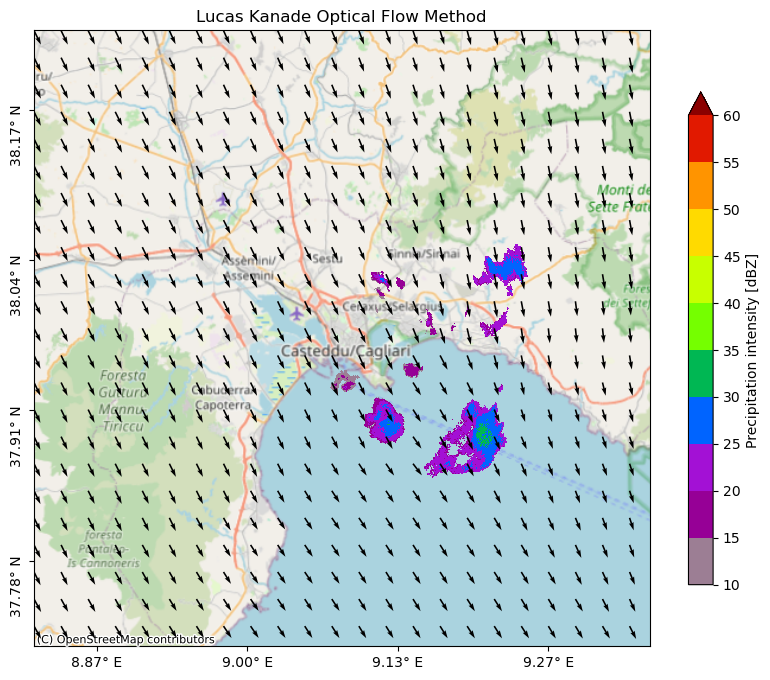

In [22]:
# Plot precipitation field and motion field
import matplotlib.pyplot as plt
from pysteps.visualization import plot_precip_field, quiver

fig, ax = plt.subplots(figsize=(10, 8))
# Precipitation field
plot_precip_field(
    R_X_dbz[2, :, :], 
    ptype="intensity", 
    geodata=metadata_X, 
    units="dBZ", 
    title="Lucas Kanade Optical Flow Method", 
    ax=ax, 
    colorscale="pysteps"
)
# Motion field (quiver plot)
quiver(V1, geodata=metadata_X, step=45, ax=ax)
utility.plot_modification(ax,metadata_X)

# Motion Field Estimation- Variational echo tracking (VET) Method
## It needs only  3 scans

Running VET algorithm
original image shape: (3, 1024, 1024)
padded image shape: (3, 1024, 1024)
padded template_image image shape: (3, 1024, 1024)

Number of sectors: 2,2
Sector Shape: (np.int64(512), np.int64(512))
Minimizing

residuals 3660113.7442703657
smoothness_penalty 0.0
original image shape: (3, 1024, 1024)
padded image shape: (3, 1024, 1024)
padded template_image image shape: (3, 1024, 1024)

Number of sectors: 4,4
Sector Shape: (np.int64(256), np.int64(256))
Minimizing

residuals 3627039.9975325842
smoothness_penalty 0.18466250938667192
original image shape: (3, 1024, 1024)
padded image shape: (3, 1024, 1024)
padded template_image image shape: (3, 1024, 1024)

Number of sectors: 16,16
Sector Shape: (np.int64(64), np.int64(64))
Minimizing

residuals 3604037.2138600335
smoothness_penalty 6.422971511431489
original image shape: (3, 1024, 1024)
padded image shape: (3, 1024, 1024)
padded template_image image shape: (3, 1024, 1024)

Number of sectors: 32,32
Sector Shape: (np.int64

C:\Users\Utente\anaconda3\envs\radar_nowcasting_env\lib\site-packages\pysteps\visualization\utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(
C:\Users\Utente\anaconda3\envs\radar_nowcasting_env\lib\site-packages\pysteps\visualization\utils.py:439: UserWarning: cartopy package is required for the get_geogrid function but it is not installed. Ignoring geographical information.
  warnings.warn(


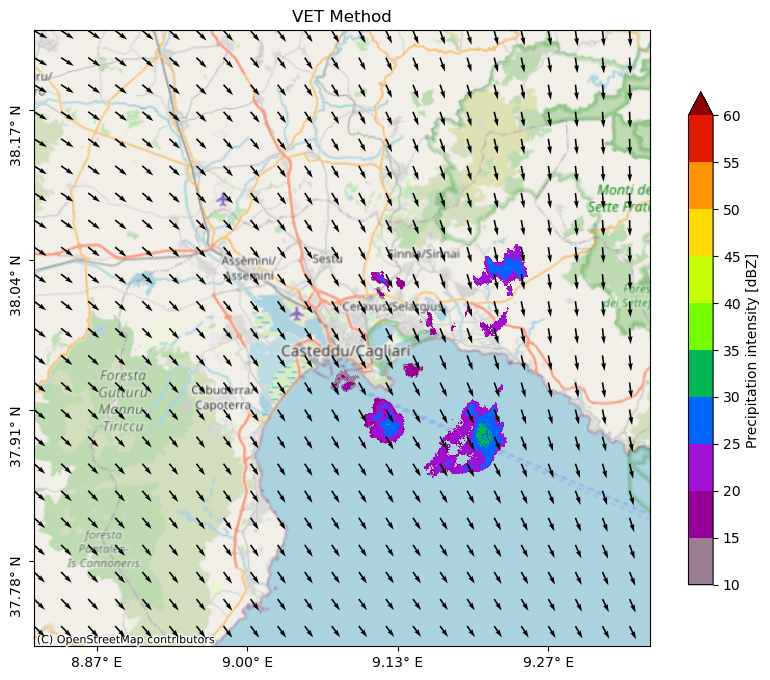

In [15]:
oflow_method = pysteps.motion.get_method("VET")
V2 = oflow_method(image_R[0:3, :, :])

# Plot the motion field
fig, ax = plt.subplots(figsize=(10, 8))
# Precipitation field
plot_precip_field(
    R_X_dbz[2, :, :], 
    ptype="intensity", 
    geodata=metadata_X, 
    units="dBZ", 
    title="VET Method", 
    ax=ax, 
    colorscale="pysteps"
)
quiver(V2, geodata=metadata_X, step=45,ax=ax)
utility.plot_modification(ax,metadata_X)

# Motion Field Estimation - Dynamic and adaptive radar tracking of storms (DARTS)
## It needs last 10 scans

In [ ]:
oflow_method = pysteps.motion.get_method("DARTS")
image_R[~np.isfinite(image_R)] = metadata_X["zerovalue"]
V3 = oflow_method(image_R[0:10,:,:])  # needs longer training sequence

In [ ]:
# Plot the motion field
fig, ax = plt.subplots(figsize=(10, 8))
# Precipitation field
plot_precip_field(
    R_X_dbz[9, :, :], 
    ptype="intensity", 
    geodata=metadata_X, 
    units="dBZ", 
    title="DARTS Method", 
    ax=ax, 
    colorscale="pysteps"
)
quiver(V3, geodata=metadata_X, step=45,ax=ax)
utility.plot_modification(ax,metadata_X)

# Motion Field Estimation -  Anisotropic Diffusion Method 
## It need only last 2 scans

In [ ]:
oflow_method = pysteps.motion.get_method("proesmans")
image_R[~np.isfinite(image_R)] = metadata_X["zerovalue"]
V4 = oflow_method(image_R[0:2, :, :])

In [ ]:
# Plot the motion field
fig, ax = plt.subplots(figsize=(10, 8))
# Precipitation field
plot_precip_field(
    R_X_dbz[1, :, :], 
    ptype="intensity", 
    geodata=metadata_X, 
    units="dBZ", 
    title="Anisotropic Diffusion Method ", 
    ax=ax, 
    colorscale="pysteps"
)
quiver(V4, geodata=metadata_X, step=45,ax=ax)
utility.plot_modification(ax,metadata_X)